In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import cv2
import scipy.ndimage
import numpy as np
from matplotlib import pyplot as plt
import util
import glob

from scipy import signal
import math
import collections

verbose = False

In [2]:
image_folder_lst = ['../projects/contact_front/MR_NewCam']
eng = util.Image_Engine(image_folder_lst, '2015-08-04_DFI28-*.png', doSort=True, color=True)

print "Read %d images from %s" % (eng.cnt(), image_folder_lst[0])

Read 20 images from ../projects/contact_front/MR_NewCam


In [6]:
def deltaImage(bg_img, fg_img, thresh_val):
    bg_img = cv2.GaussianBlur(bg_img, (5, 5), 0)
    bg_img_gray = cv2.cvtColor(bg_img, cv2.COLOR_BGR2GRAY)
    #avg = bg_img.copy().astype("float")
    
    img = cv2.cvtColor(fg_img, cv2.COLOR_BGR2HSV)
    chan = cv2.split(img)[2]
    chan_blurred = cv2.medianBlur(chan, 5)

    delta_image = cv2.absdiff(bg_img_gray, chan_blurred)
    #img_thresh = cv2.adaptiveThreshold(delta_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 7, 5)
    ret,delta_image_thresh = cv2.threshold(delta_image, thresh_val, 255, cv2.THRESH_BINARY)
    return delta_image_thresh

def calulateDeltaRatio(img1, img2):
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    delta_img = deltaImage(bg_img, fg_img, 5)
    #blue_chan_mean = np.abs(np.mean(blue_chan))
    hist = np.bincount(delta_img.ravel(),minlength=256)
    ratio = float(hist[-1])/float(hist[0])
    return hist[0], hist[1], ratio, delta_img

blacks: 1121600, whites: 0, ratio: 0.11820


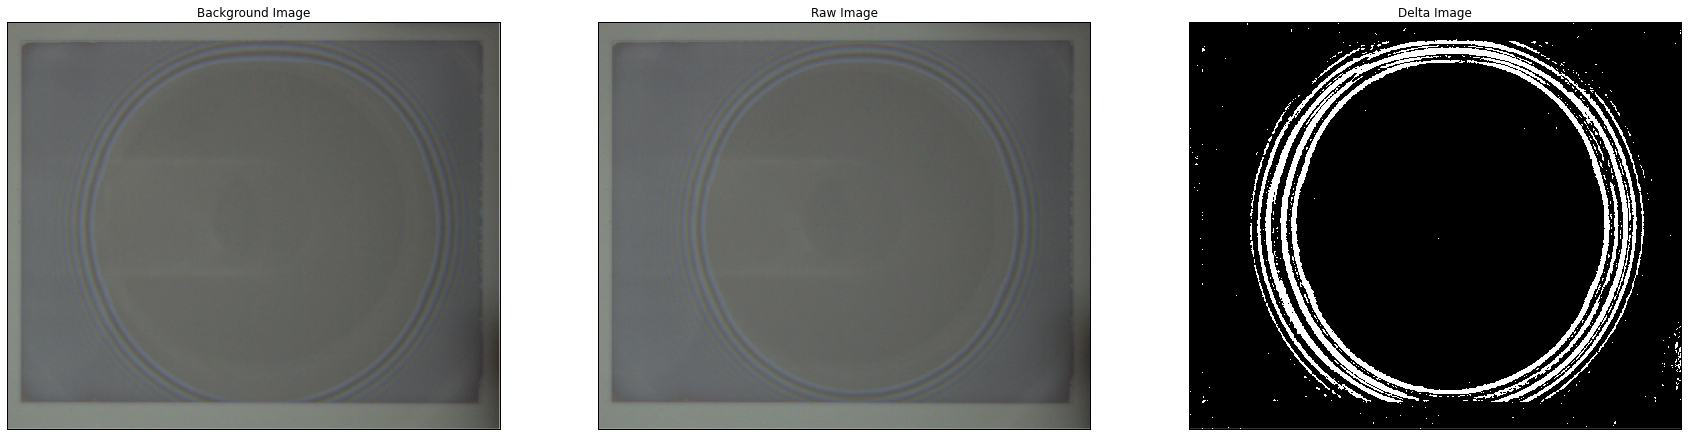

In [8]:
fg_num = 6
bg_img = eng.images[fg_num-1].copy()
fg_img = eng.images[fg_num].copy()

# #delta_img = cv2.absdiff(bg_img, fg_img)
# delta_img = deltaImage(bg_img, fg_img, 5)

# hist = np.bincount(delta_img.ravel(),minlength=256)
# plt.plot(hist)

# blacks = hist[0]
# whites = hist[-1]
# ratio = float(whites)/float(blacks)

blacks, whites, ratio, delta_img = calulateDeltaRatio(bg_img, fg_img)

print ("blacks: %d, whites: %d, ratio: %.5f" % (blacks, whites, ratio))

util.plot_imgs([(bg_img, 'Background Image'), (fg_img, 'Raw Image'), (delta_img, 'Delta Image')], color=False)

In [ ]:
video_file_path = '/data/projects/contact_front/MR_NewCam/2015-08-04_DFI28.mp4'

cap = cv2.VideoCapture(video_file_path)

cnt = 0
prev_img = None

ratios = []
while(cap.isOpened()):
    ret, new_img = cap.read()
    cnt += 1
    
    if ret:
        if prev_img == None:
            prev_img = new_img
            continue

        blacks, whites, ratio, d = calulateDeltaRatio(prev_img, new_img)
        ratios.append(ratio)
cap.release()
print "Done processing ", cnt, " images..."
print "Found ", len(ratios), " data pts:"
plt.figure(figsize=(10*2,5))
plt.plot(ratios, color='b')
plt.title('RGB mean values from center ROI')

### 